### Assignment 4.1 Analysing stratification

In this tutorial, we will be using the [NCEP Global Ocean Data Assimilation System (GODAS) datasets](https://psl.noaa.gov/data/gridded/data.godas.html) to analyze the properties of stratified waters ourselves. GODAS is a global analysis and reanalysis ocean dataset covering the period from 1980 till now (updated monthly).  

Download the year 2020 monthly mean ['potential temperature'](https://psl.noaa.gov/cgi-bin/db_search/DBListFiles.pl?did=98&tid=83478&vid=1913) and ['salinity'](https://psl.noaa.gov/cgi-bin/db_search/DBListFiles.pl?did=98&tid=83478&vid=1914) from the GODAS website at https://psl.noaa.gov/data/gridded/data.godas.html (click the 'Number of files' icon to expand, search the 2020 file and hit the download button). 

In [1]:
import gsw
import numpy as np
import xarray as xr
import cmocean
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

Now open the the temperature and salinity files for 2020 (where of course `datadir` should point to the directory where you saved the GODAS data)

In [2]:
datadir = '/Users/erik/Downloads/'

T = xr.open_dataset(f"{datadir}pottmp.2020.nc")
S = xr.open_dataset(f"{datadir}salt.2020.nc")

### Assignment

**a)** Create a figure by writing code that plots four panels showing potential temperature, salinity, potential density ($\sigma_0$), and buoyancy frequency (or period) along a latitudinal section at the 30W and along a longitudinal section on the equator. What structures do you see?

Some hints:
- You can either write your own function for buoyancy period, or use `gsw.stability.NSquared`. 
- To create an array of pressure with the same size as salinity and temperature, use
```python
p = gsw.p_from_z(-T.level, 0)
p_arr = p.expand_dims(dim={'time':T.time, 'lat':T.lat, 'lon':T.lon}, axis=[0,2,3])
```
- To account for the fact that $N^2$ is defined at the pressure midpoints, use 
```python
level = (T.level+T.level.shift(level=1)).dropna('level')/2
```

In [3]:
# ANSWER
CT = gsw.conversions.CT_from_pt(1000*S.salt, T.pottmp-273.15)
sigma0 = gsw.density.sigma0(1000*S.salt, CT)
p = gsw.p_from_z(-T.level, 0)
p_arr = p.expand_dims(dim={'time':T.time, 'lat':T.lat, 'lon':T.lon}, axis=[0,2,3])
n2, _ = gsw.stability.Nsquared(1000*S.salt, CT, p_arr, axis=1)
level = (T.level+T.level.shift(level=1)).dropna('level')/2
N2 = xr.DataArray(data=n2,
                  dims=('time','level','lat','lon'),
                  coords={'time':T.time,'level':level,'lat':T.lat,'lon':T.lon})

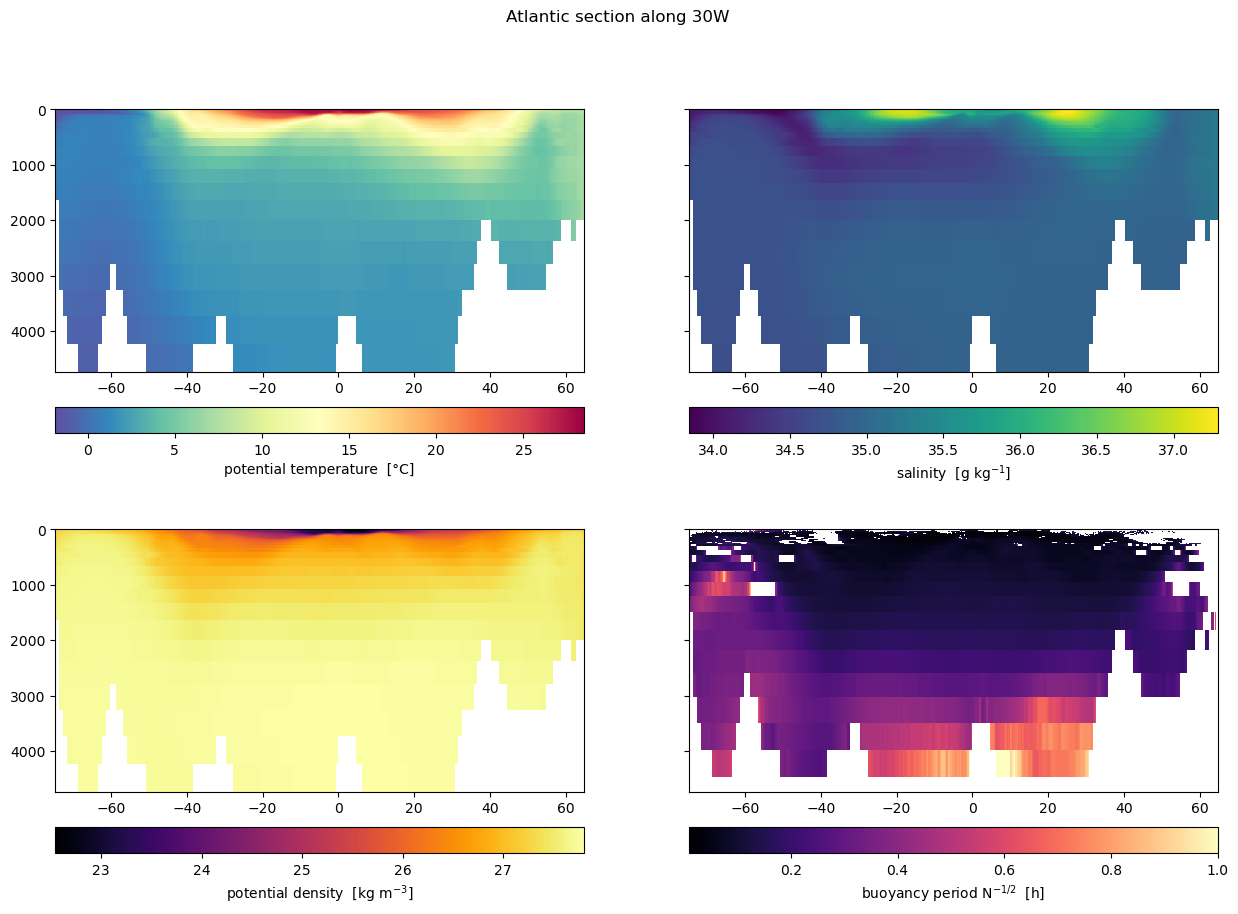

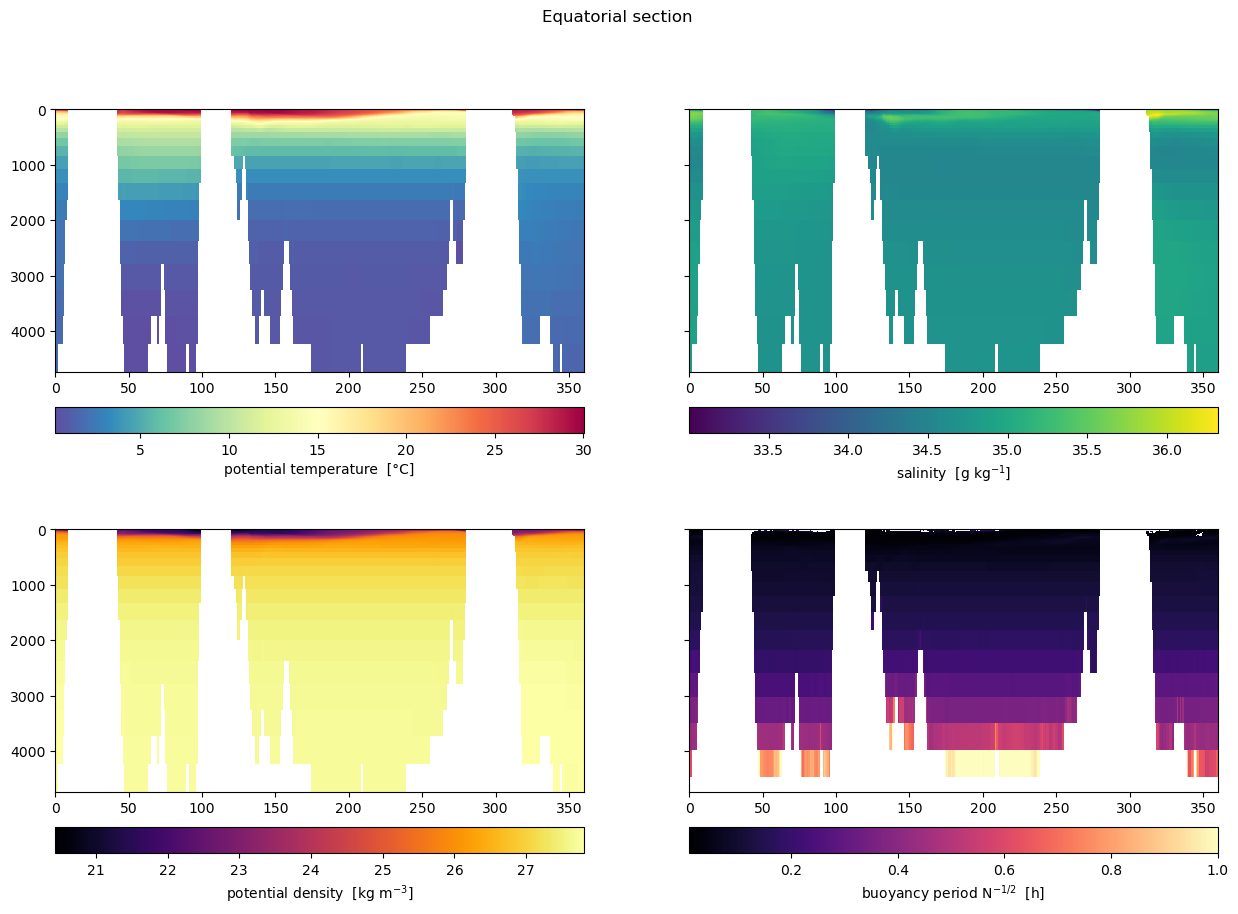

In [4]:
# ANSWER
def section(da, which={'lon':330}):
    """ returns time mean"""
    return da.sel(**which, method='nearest').mean('time')

def plot_section(which, title=None):
    f, ax = plt.subplots(2,2, figsize=(15,10), sharey=True)
    if title is not None:  f.suptitle(title)
    cbkw = dict(orientation='horizontal', pad=0.1)
    if 'lat' in which:  x = T.lon
    elif 'lon' in which:  x = T.lat

    # temperature
    im = ax[0,0].pcolormesh(x, T.level, section(T.pottmp, which)-273.15, cmap='Spectral_r')
    plt.colorbar(im, ax=ax[0,0], label='potential temperature  [°C]', **cbkw)
    ax[0,0].invert_yaxis()

    # salinity
    im = ax[0,1].pcolormesh(x, S.level, 1000*section(S.salt, which))
    plt.colorbar(im, ax=ax[0,1], label=r'salinity  [g kg$^{-1}$]', **cbkw)

    # density
    im = ax[1,0].pcolormesh(x, sigma0.level, section(sigma0, which), cmap='inferno')
    plt.colorbar(im, ax=ax[1,0], label=r'potential density  [kg m$^{-3}$]', **cbkw)

    # stratification
    im = ax[1,1].pcolormesh(x, N2.level, section(1/np.sqrt(N2.clip(min=0)), which)/3600, cmap='magma', vmax=1)
    plt.colorbar(im, ax=ax[1,1], label=r'buoyancy period N$^{-1/2}$  [h]', **cbkw)

plot_section({'lon':330}, title='Atlantic section along 30W')
plot_section({'lat':0}, title='Equatorial section')

**b)** Investigate the Mixed Layer Depth. A common way (e.g. in the Climatological Atlas of the World Ocean by Levitus, 1982) to define this Mixed Layer Depth is as the depth at which the potential density becomes larger than the surface density plus 0.125 kg/m^3.

Plot a global map of the mixed layer depth for the 2020 annual average, for January 2020, and for July 2020. What differences do you see?

In [5]:
# ANSWER
def mixed_layer(PD):
    return PD.level.where(PD-PD.isel(level=0)>0.0125,np.nan).min('level')


MXL_Ann = mixed_layer(sigma0.mean('time'))
MXL_Jan = mixed_layer(sigma0.isel(time=0))
MXL_Jul = mixed_layer(sigma0.isel(time=6))

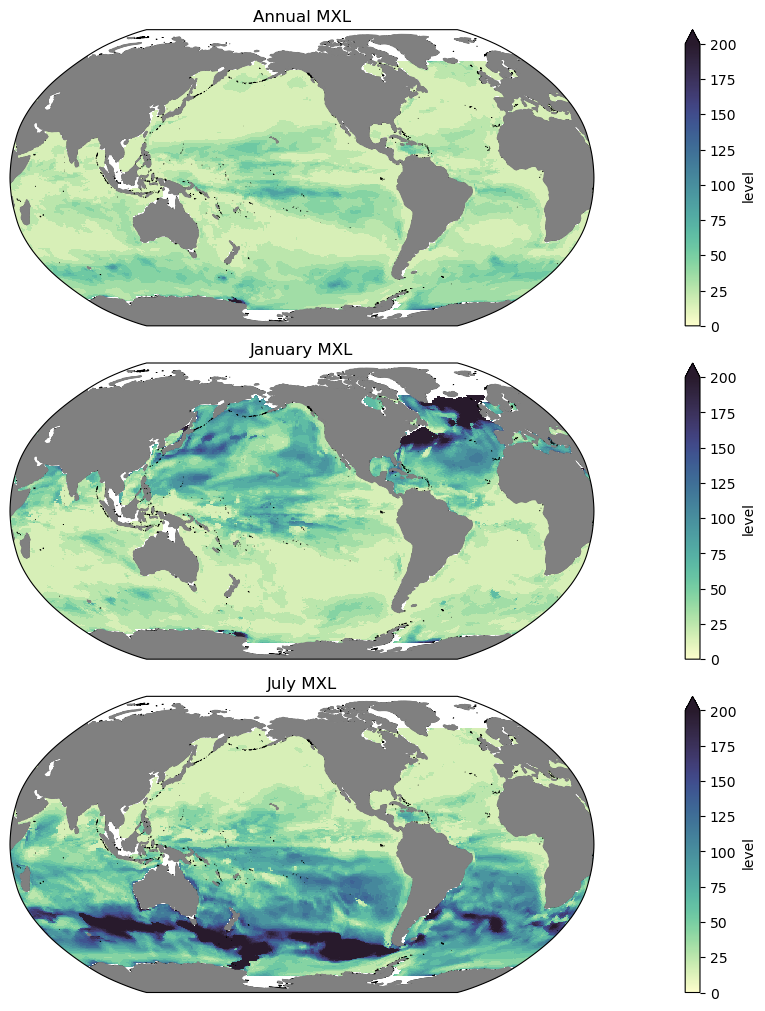

In [6]:
# ANSWER
fig = plt.figure(figsize=(20, 10), constrained_layout=True)
kw = dict(transform=ccrs.PlateCarree(), cmap='cmo.deep', vmin=0, vmax=200)
proj = ccrs.Robinson(central_longitude=220)

def map_details(ax, title=None):
    ax.coastlines(resolution='50m', lw=.5)
    ax.add_feature(cfeature.LAND, color='grey', zorder=2)
    ax.set_global()
    if title is not None:  ax.set_title(title)
    return

ax = fig.add_subplot(3, 1, 1, projection=proj)
MXL_Ann.plot(ax=ax, **kw)
map_details(ax, title='Annual MXL')

ax = fig.add_subplot(3, 1, 2, projection=proj)
MXL_Jan.plot(ax=ax, **kw)
map_details(ax, title='January MXL')

ax = fig.add_subplot(3, 1, 3, projection=proj)
MXL_Jul.plot(ax=ax, **kw)
map_details(ax, title='July MXL')